This notebook is part of [**Byron v0.8**](https://pypi.org/project/byron/)  
Copyright 2023-24 Giovanni Squillero and Alberto Tonda  
SPDX-License-Identifier: [Apache-2.0](https://www.apache.org/licenses/LICENSE-2.0) 

In [1]:
import byron

/var/folders/31/dkl97hks2c14b663vl55pt440000gn/T/ipykernel_17001/1429530752.py:1: ByronPerformanceWarning: 
  Paranoia checks are enabled in this notebook: performances can be significantly impaired
  [see https://cad-polito-it.github.io/byron/paranoia for details]
  import byron


# Assembly Tutorial

Oversimplified assembler vaguely based on x86 assembly 

### Operands: Registers and Immediate 

In [2]:
reg8 = byron.f.choice_parameter(['ah', 'bh', 'ch', 'dh', 'al', 'bl', 'cl', 'dl'])
reg16 = byron.f.choice_parameter(['ax', 'bx', 'cx', 'dx'])
int8 = byron.f.integer_parameter(0, 2 ** 8)
int16 = byron.f.integer_parameter(0, 2 ** 16)

### Operands: Registers and Immediate

See https://docs.python.org/3/library/string.html#formatspec for the format specification

In [3]:
opcodes2 = byron.f.choice_parameter(['mov', 'add', 'sub', 'or', 'and'])
opcodes1 = byron.f.choice_parameter(['not', 'neg', 'inc', 'dec'])
opcodes0 = byron.f.choice_parameter(['nop', 'hlt'])

inst8rr = byron.f.macro("{op} {r1}, {r2}", op=opcodes2, r1=reg8, r2=reg8)
inst8ri = byron.f.macro("{op} {r}, {i:#x}", op=opcodes2, r=reg8, i=int8)
inst8r = byron.f.macro("{op} {r}", op=opcodes1, r=reg8)

inst16rr = byron.f.macro("{op} {r1}, {r2}", op=opcodes2, r1=reg16, r2=reg16)
inst16ri = byron.f.macro("{op} {r}, {i:#x}", op=opcodes2, r=reg16, i=int16)
inst16r = byron.f.macro("{op} {r}", op=opcodes1, r=reg16)

### A simple fragment of code

In [4]:
prog = byron.f.bunch([inst16rr, inst16ri, inst16r, inst8rr, inst8ri, inst8r], 5)
byron.f.as_text(prog)


; 🖋 n1 ➜ Frame❬MacroArray#1❭
and ax, ax  ; 🖋 n1.n2 ➜ Macro❬User#4❭
not ah  ; 🖋 n1.n3 ➜ Macro❬User#3❭
dec ax  ; 🖋 n1.n4 ➜ Macro❬User#6❭
and ax, 0x6ff1  ; 🖋 n1.n5 ➜ Macro❬User#5❭
sub dx, 0x65ce  ; 🖋 n1.n6 ➜ Macro❬User#5❭



### Let's add subroutines

In [5]:
sub_entry = byron.f.macro("\nproc {_node} near", _label='')
sub_exit = byron.f.macro("ret")
sub_body = byron.f.bunch([inst16rr, inst16ri, inst16r, inst8rr, inst8ri, inst8r], 3)
sub = byron.f.sequence([sub_entry, sub_body, sub_exit])

call = byron.f.macro("call {proc}", proc=byron.f.global_reference(sub, first_macro=True, creative_zeal=1))

Let's create a full program with header, initialization, and main body. Let "calls" be more frequent than the other instructions (62.5% of macros in `main_body` will be `call`). 

In [6]:
main_prologue = """section .text

global _start
_start:
"""

main_body = byron.f.bunch([inst16rr, inst16ri, inst16r, inst8rr, inst8ri, inst8r, call],
                          size=10,
                          weights=[1, 1, 1, 1, 1, 1, 10])
init = byron.f.macro("mov ax, {v:#x}\nmov bx, {v:#x}\nmov cx, {v:#x}\nmov dx, {v:#x}", v=int16)

full_prog = byron.f.sequence([main_prologue, init, main_body])

In [7]:
byron.f.as_text(full_prog)

; 🖋 n7 ➜ Frame❬FrameSequence#2❭
section .text

global _start
_start:
  ; 🖋 n7.n8 ➜ Macro❬Text#3❭
mov ax, 0x2ff8
mov bx, 0x2ff8
mov cx, 0x2ff8
mov dx, 0x2ff8  ; 🖋 n7.n9 ➜ Macro❬User#8❭
; 🖋 n7.n10 ➜ Frame❬MacroArray#3❭
and bx, ax  ; 🖋 n7.n10.n11 ➜ Macro❬User#4❭
call n22  ; 🖋 n7.n10.n12 ➜ Macro❬User#7❭
call n22  ; 🖋 n7.n10.n13 ➜ Macro❬User#7❭
call n29  ; 🖋 n7.n10.n14 ➜ Macro❬User#7❭
add ah, 0x62  ; 🖋 n7.n10.n15 ➜ Macro❬User#2❭
and ch, al  ; 🖋 n7.n10.n16 ➜ Macro❬User#1❭
inc ax  ; 🖋 n7.n10.n17 ➜ Macro❬User#6❭
call n29  ; 🖋 n7.n10.n18 ➜ Macro❬User#7❭
or cx, 0x8e52  ; 🖋 n7.n10.n19 ➜ Macro❬User#5❭
and cx, cx  ; 🖋 n7.n10.n20 ➜ Macro❬User#4❭
; 🖋 n21 ➜ Frame❬FrameSequence#1❭

proc n22 near  ; 🖋 n21.n22 ➜ Macro❬Text#1❭
; 🖋 n21.n23 ➜ Frame❬MacroArray#2❭
add bx, 0x8e6f  ; 🖋 n21.n23.n24 ➜ Macro❬User#5❭
or cl, ch  ; 🖋 n21.n23.n25 ➜ Macro❬User#1❭
and cl, 0x4f  ; 🖋 n21.n23.n26 ➜ Macro❬User#2❭
ret  ; 🖋 n21.n27 ➜ Macro❬Text#2❭
; 🖋 n28 ➜ Frame❬FrameSequence#1❭

proc n29 near  ; 🖋 n28.n29 ➜ Macro❬Text#1❭
; 

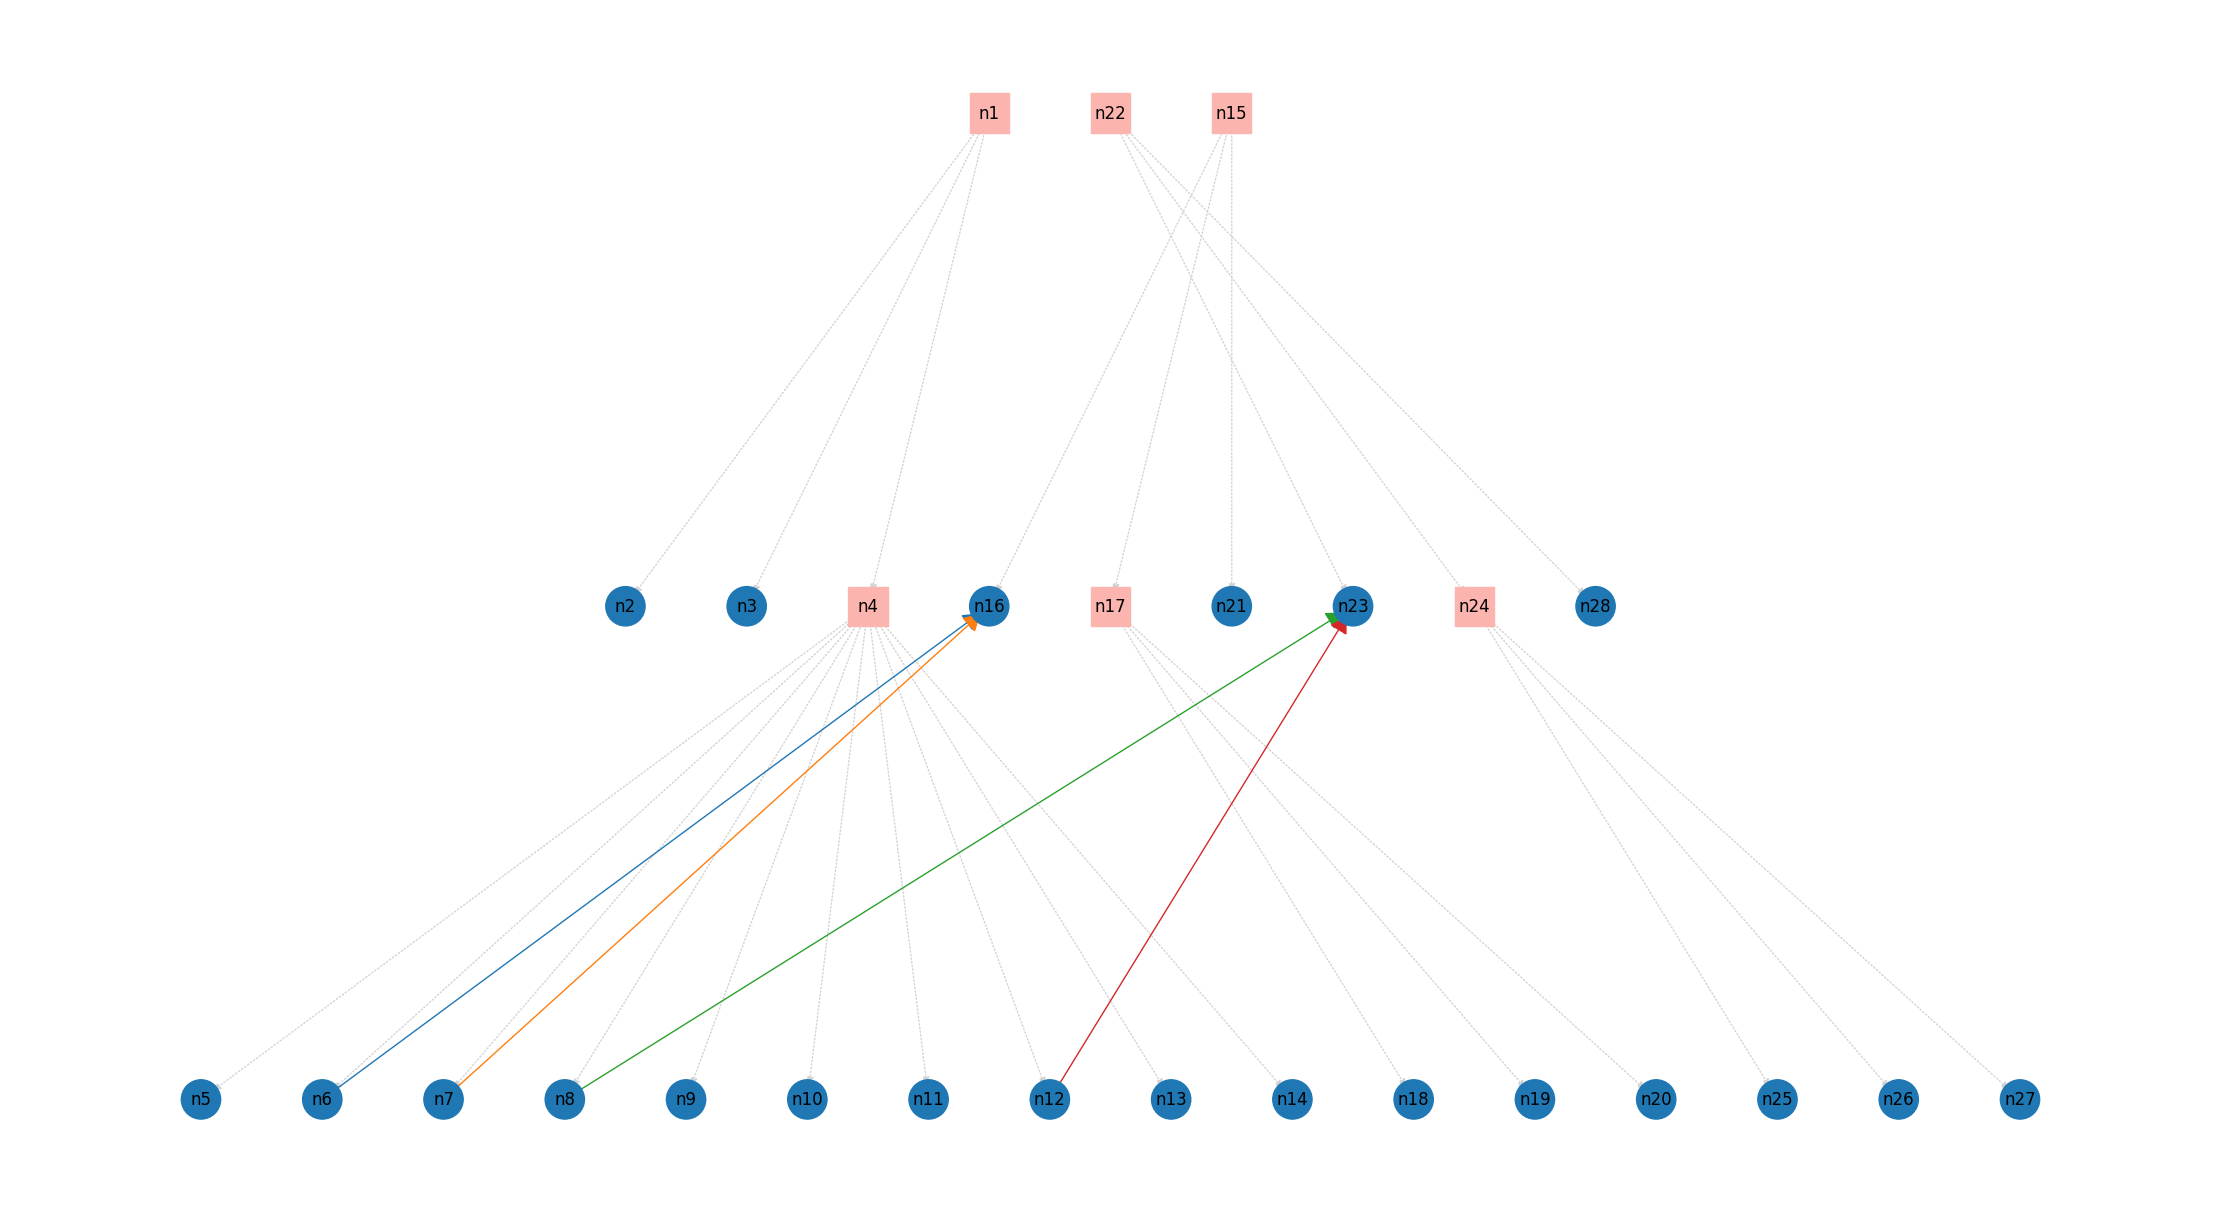

In [8]:
byron.f.as_forest(full_prog)

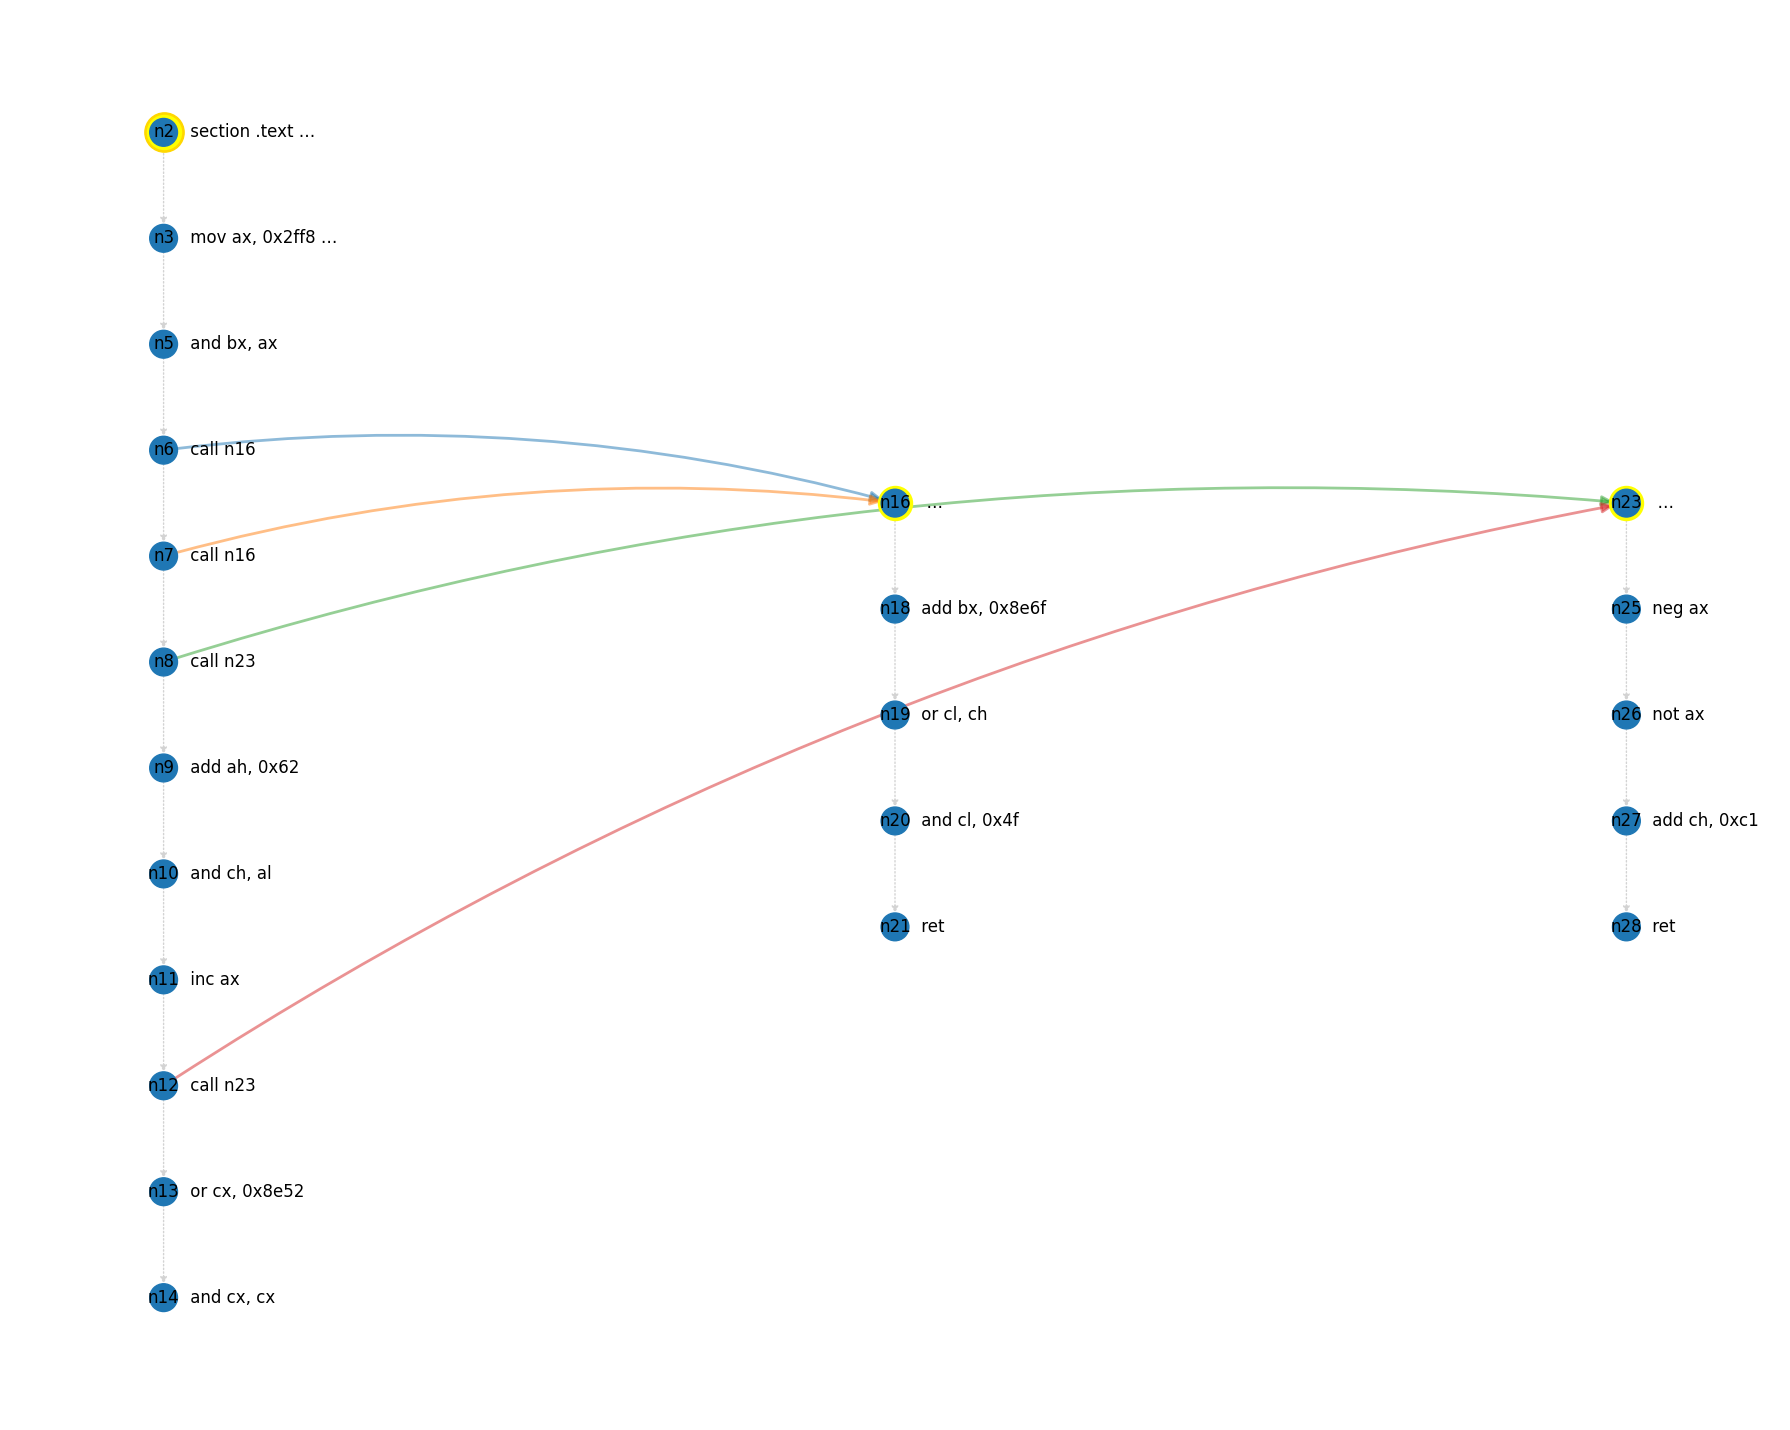

In [9]:
byron.f.as_lgp(full_prog)